## Imports and Helpers

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
from Model_class import *
from ICML_utils import *
%matplotlib inline

## Configuration Settings

In [2]:
data_dir = "../data/"

labels_infile = f"{data_dir}labels_example.tsv"
model_infile = "../model/model.pt"
image_type = 'png'

In [3]:
model_infile

'../model/model.pt'

In [4]:
output_path = "../output"
if not os.path.exists(output_path):
    os.makedirs(output_path)

## Load Model

In [5]:
r_model = MyModel()    
r_model.load_state_dict(torch.load(model_infile))
r_model.eval()

MyModel(
  (Model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0

## Load Labels, Images & Predict

In [6]:
image_pool = os.listdir(data_dir)
image_pool = [x for x in image_pool if '.png' in x]
cases_pool = [x.split('.')[0] for x in image_pool]

In [7]:
image_pool

['real_variant.png', 'artifact.png']

In [8]:
cases_pool

['real_variant', 'artifact']

In [9]:
if not os.path.isfile(f"{output_path}/labels.csv"):
    
    labels = pd.read_csv(labels_infile, sep="\t").set_index("name")
    labels = labels.loc[cases_pool,:]

    y_prob = []
    y_pred = []
    y_res = []

    for pos,name in enumerate(cases_pool):

        origim,input_image = read_png_as_tensor(data_dir+image_pool[pos], 221, 221)
        
        y_prob.append(torch.softmax(r_model(input_image),dim=1).detach().numpy()[0,1])
        y_pred.append(int(np.round(y_prob[pos])))
        y_label = labels.loc[name,'label']
        y_res.append(classify_res(y_label,y_pred[pos]))

    labels['prob'] = y_prob
    labels['pred'] = y_pred
    labels['res'] = y_res

    labels.to_csv(f"{output_path}/labels.csv")
    
else:
    
    labels = pd.read_csv(f"{output_path}/labels.csv", sep=",").set_index("name")

labels

,label,prob,pred,res
name,,,,
real_variant,0,0.426288,0,TN
artifact,1,0.999441,1,TP


## Generate Maps

In [10]:
r_model = r_model.double()

In [11]:
target_list = [0,1]

real_variant
0
real_variant
1
artifact
0
artifact
1


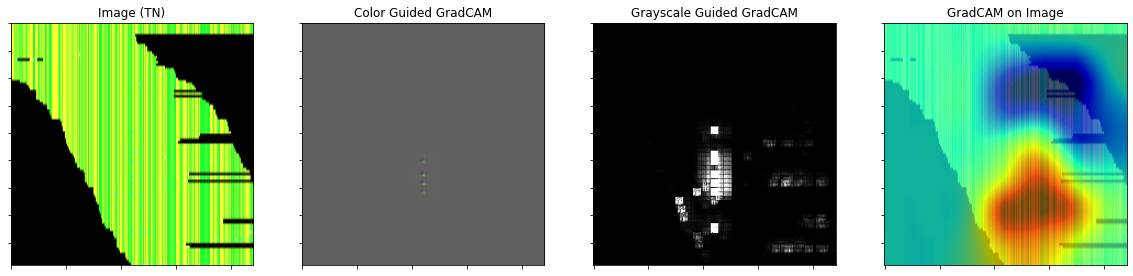

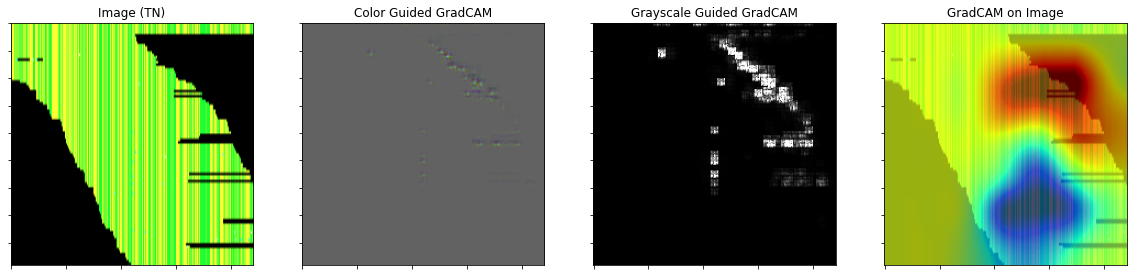

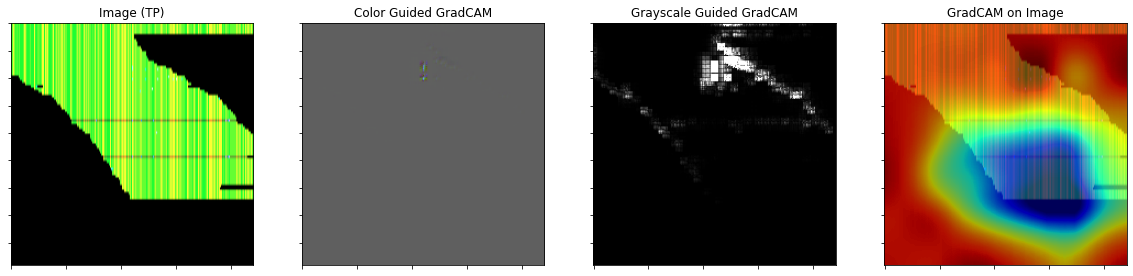

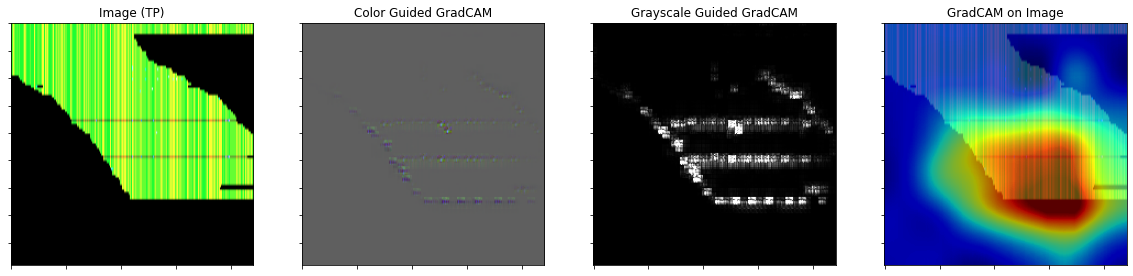

In [13]:
for pos,name in enumerate(cases_pool):
    
    for target in target_list:
    
        savefile = f"{output_path}/{name}_target{target}.png"

        print(name)
        print(target)
        origim,input_image = read_png_as_tensor(data_dir+image_pool[pos], 221, 221)

        input_image = input_image.double()

        input_image = input_image.requires_grad_(True)

        # Compute GradCAM
        cam_reduced, cam = custom_generate_cam(input_image, r_model, target_class=target)

        # Compute Guided Grads

        GBP = GuidedBackprop(r_model,list(r_model.named_modules())[2][0])

        guided_grads = GBP.generate_gradients(input_image, target_class=target)

        for k, v in GBP.hooksfor.items():
            GBP.hooksfor[k].remove()
        for k, v in GBP.hooksback.items():
            GBP.hooksback[k].remove()

        GBP.hookbacksingle.remove()

        # Compute Guided GradCAM
        cam_gb = guided_grad_cam(cam[0], guided_grads[0])

        # Prepare Guided GradCAM images
        cam_gb_norm_orig = normalize_gradient_image(cam_gb)
        cam_gb_norm_orig *= 255
        cam_gb_norm_orig_im = Image.fromarray(cam_gb_norm_orig.astype("uint8").transpose(1,2,0))

        grayscale_cam_gb_orig = convert_to_grayscale(cam_gb)
        grayscale_cam_gb_orig_cast = np.repeat(grayscale_cam_gb_orig, 3, axis=0)
        grayscale_cam_gb_orig_cast *= 255
        grayscale_cam_gb_orig_im = Image.fromarray(grayscale_cam_gb_orig_cast.astype("uint8").transpose(1, 2, 0))

        fig = plt.figure(figsize=(20, 20))

        ax = fig.add_subplot(1, 4, 1)
        ax.set_yticklabels([])
        ax.set_xticklabels([])

        transform = T.ToPILImage()

        ax.imshow(transform(origim))
        ax.set_title("Image (" + labels.loc[name,'res'] + ")")

        ax = fig.add_subplot(1, 4, 2)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.imshow(cam_gb_norm_orig_im)
        ax.set_title("Color Guided GradCAM")

        ax = fig.add_subplot(1, 4, 3)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.imshow(grayscale_cam_gb_orig_im)
        ax.set_title("Grayscale Guided GradCAM")

        ax = fig.add_subplot(1, 4, 4)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.imshow(transform(origim))
        ax.imshow(cam[0,:,:], alpha=0.7, cmap='jet');
        ax.set_title("GradCAM on Image")

        fig.savefig(savefile)